In [59]:
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.plot import show
from matplotlib import colors
from skimage import exposure
from sklearn.metrics import confusion_matrix
import geopandas as gpd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import pickle
import itertools

In [2]:
class_label = glob.glob('./Shape_files/*shp')
class_label

['./Shape_files/class_name_Urban.shp',
 './Shape_files/class_name_BareLand.shp',
 './Shape_files/class_name_Farm.shp',
 './Shape_files/class_name_Forest.shp',
 './Shape_files/class_name_Water.shp',
 './Shape_files/class_name_Cloud.shp']

In [3]:
building_shape = gpd.read_file(class_label[0])
building_shape

,id,class_name,class1,geometry
0,10,Urban,3,POLYGON ((277345.2154606701 -3756456.897802229...
1,11,Urban,3,POLYGON ((276196.4266609224 -3757782.791541938...
2,12,Urban,3,"POLYGON ((356993.3755881815 -3724022.76068935,..."
3,13,Urban,3,POLYGON ((275467.6637660824 -3761606.104266092...


In [4]:
classes = pd.DataFrame({'Name':building_shape.class_name.values,'Class':building_shape.class1})



In [5]:
def dir_location(date,band):
    directory  = '/vault/users/dara104/CleanedImage/*'+band+'*'+date+'*tif'
    bands      = glob.glob(directory)
    img        = rasterio.open(bands[0])
    return img

#Get shape geometry in json format
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

#Functing for getting classes
def getClases(shp,date = '20141002'):
    class_df = pd.DataFrame()
    df_ls = []
    
    img_blue   = dir_location(date,band='blue')
    img_green  = dir_location(date,band='green')
    img_red    = dir_location(date,band='red')
    img_nir    = dir_location(date,band='nir')
    img_swir   = dir_location(date,band='swir')


    geom = gpd.read_file(shp)
    geom = geom.to_crs(crs=img_red.crs.data)
    sa   = np.arange(len(geom))
    sb   = np.arange(1, len(geom)+1)
    for a,b, in zip(sa, sb):
        cord1 = getFeatures(geom.iloc[a:b,:])
        out_blue, out_transform   = mask(img_blue, cord1, crop=True)
        out_green, out_transform1 = mask(img_green, cord1, crop=True)
        out_red, out_transform2   = mask(img_red, cord1, crop=True)
        out_nir, out_transform3   = mask(img_nir, cord1, crop=True)
        out_swir, out_transform4   = mask(img_swir, cord1, crop=True)
        

        df_ls.append(pd.DataFrame({'Blue_Band':out_blue.ravel(),#*0.0001,
                              'Green_Band':out_green.ravel(),#*0.0001,
                              'Red_Band':out_red.ravel(),#*0.0001,
                              'NIR_Band':out_nir.ravel(),#*0.0001,
                              'SWIR_Band':out_swir.ravel(),#*0.0001,
                              'Class':geom.class1[0]}))

    class_df = pd.concat(df_ls, axis=0)
    class_df = class_df.replace([0.0, 0.000000, -0.9999], np.nan)
    return class_df

In [6]:
cls_df = pd.DataFrame()
df_ls = []
for s in class_label[0:len(class_label)-1]:
    df_ls.append(getClases(s))
    
cls_df = pd.concat(df_ls, axis=0)

In [7]:
cls_df.groupby('Class').count()

,Blue_Band,Green_Band,Red_Band,NIR_Band,SWIR_Band
Class,,,,,
2,541,541,541,541,541
3,475,475,475,475,475
4,1222,1222,1222,1222,1222
5,774,774,774,774,774
6,883,883,883,883,883


In [8]:
cls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 35
Data columns (total 6 columns):
Blue_Band     3895 non-null float32
Green_Band    3895 non-null float32
Red_Band      3895 non-null float32
NIR_Band      3895 non-null float32
SWIR_Band     3895 non-null float32
Class         7453 non-null int64
dtypes: float32(5), int64(1)
memory usage: 262.0 KB


In [9]:
cls_df = cls_df.fillna(-999)
cls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 35
Data columns (total 6 columns):
Blue_Band     7453 non-null float32
Green_Band    7453 non-null float32
Red_Band      7453 non-null float32
NIR_Band      7453 non-null float32
SWIR_Band     7453 non-null float32
Class         7453 non-null int64
dtypes: float32(5), int64(1)
memory usage: 262.0 KB


In [10]:
cls_df.loc[cls_df['Red_Band'] == -999, 'Class'] = 1
cls_df.loc[cls_df['Blue_Band'] == -999, 'Class'] = 1
cls_df.loc[cls_df['Green_Band'] == -999, 'Class'] = 1
cls_df.loc[cls_df['NIR_Band'] == -999, 'Class'] = 1
cls_df.loc[cls_df['SWIR_Band'] == -999, 'Class'] = 1

In [11]:
cls_df.groupby('Class').count()

,Blue_Band,Green_Band,Red_Band,NIR_Band,SWIR_Band
Class,,,,,
1,3558,3558,3558,3558,3558
2,541,541,541,541,541
3,475,475,475,475,475
4,1222,1222,1222,1222,1222
5,774,774,774,774,774
6,883,883,883,883,883


In [12]:
cls_df.to_csv('data.csv')

In [13]:
data         = pd.read_csv('data.csv', index_col=0).reset_index(drop=True)
ndvi         = (data.NIR_Band - data.Red_Band)/(data.NIR_Band + data.Red_Band)
ndwi         = (data.Green_Band - data.NIR_Band)/(data.Green_Band + data.NIR_Band)
ndbi         = (data.SWIR_Band - data.NIR_Band)/(data.SWIR_Band + data.NIR_Band)
data['NDVI'] = ndvi
data['NDWI'] = ndwi
data['NDBI'] = ndbi
data['BU']   = ndbi - ndvi
data         = data[['Blue_Band','Green_Band','Red_Band','NIR_Band','SWIR_Band','NDVI','NDWI','NDBI','BU','Class']]
data.head()
data.describe()

,Blue_Band,Green_Band,Red_Band,NIR_Band,SWIR_Band,NDVI,NDWI,NDBI,BU,Class
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,-476.859924,-476.881150,-476.857399,-476.771993,-476.806267,0.186012,-0.268750,-0.102802,-0.288813,2.699718
std,499.074532,499.054243,499.076947,499.158589,499.125829,0.380076,0.415798,0.196872,0.469850,1.880986
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.744898,-0.938976,-0.643979,-1.499945,1.000000
25%,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,-0.773734,-0.270228,-0.703433,1.000000
50%,0.025100,0.012800,0.022500,0.015700,0.004600,-0.000000,-0.000000,-0.000000,0.000000,2.000000
75%,0.099500,0.041300,0.096100,0.349100,0.182000,0.606716,-0.000000,-0.000000,0.000000,4.000000
max,0.312800,0.226500,0.428400,0.606300,0.625000,0.920798,0.647474,0.168122,0.256780,6.000000


In [14]:
# Labels are the values we want to predict
labels = np.array(data['Class'])

In [15]:
# Remove the labels from the features axis 1 refers to the columns
features= data.drop('Class', axis = 1)

In [16]:
# Saving feature names for later use
feature_list = list(features.columns)

In [17]:
# Convert to numpy array
features = np.array(features)

In [18]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [19]:
rf = RandomForestClassifier()

In [20]:
n_estimators      = np.arange(50,1000,100)
max_features      = ['auto', 'sqrt', 'log2']
min_samples_split = np.arange(10,20,1)
max_depth         = np.arange(1,10,2)
class_weight      = ['balanced']
param_grid        = dict(n_estimators=n_estimators, max_features=max_features, \
                        min_samples_split=min_samples_split, class_weight=class_weight, max_depth=max_depth)
grid  = RandomizedSearchCV(rf, param_grid, n_iter=1 , cv=5 ,scoring = "balanced_accuracy",n_jobs = -1,random_state=1)
grid.fit(train_features,train_labels)
opt_parameters = grid.best_params_
print(grid.best_params_)

{'n_estimators': 150, 'min_samples_split': 16, 'max_features': 'sqrt', 'max_depth': 7, 'class_weight': 'balanced'}


In [21]:
grid.best_score_

0.9995032887094318

In [22]:
predcited_values = grid.predict(test_features)

In [23]:
print(classification_report(test_labels, predcited_values))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       864
           2       1.00      1.00      1.00       135
           3       0.99      1.00      1.00       138
           4       1.00      1.00      1.00       294
           5       1.00      1.00      1.00       192
           6       1.00      1.00      1.00       241

   micro avg       1.00      1.00      1.00      1864
   macro avg       1.00      1.00      1.00      1864
weighted avg       1.00      1.00      1.00      1864



In [24]:
fit_model = RandomForestClassifier(**opt_parameters).fit(train_features,train_labels)
pickle.dump(fit_model, open("opt_model", 'wb'))

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.00414938 0.         0.         0.99585062]]


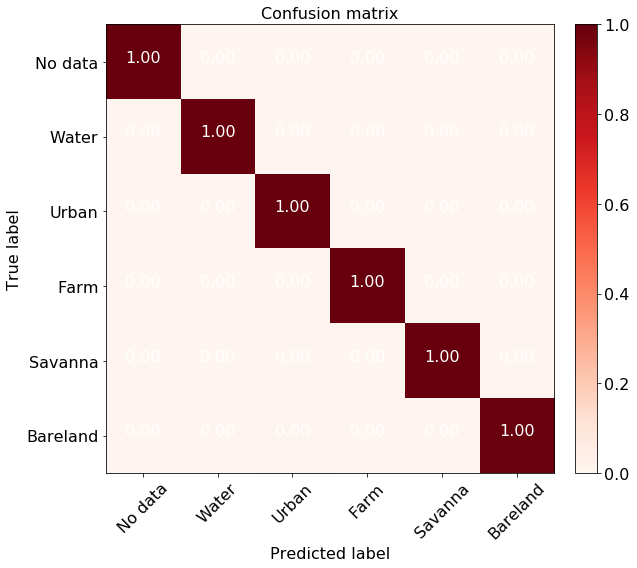

In [63]:
def plot_confusion_matrix(cm, classes_types,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
     Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(figsize=(9,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    cb=plt.colorbar(fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=16)
    tick_marks = np.arange(len(classes_types))
    plt.xticks(tick_marks, classes_types, rotation=45)
    plt.yticks(tick_marks, classes_types)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if (cm[i, j] < 0.01) or (cm[i,j] >= 0.75)  else "black",fontsize=16)
    plt.ylabel('True label',fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)
    plt.tight_layout()
    plt.savefig("confusion_mat.pdf", bbox_inches='tight', pad_inches=0.1)

classes=['No data', "Water","Urban","Farm","Savanna","Bareland"]
conf_mat = confusion_matrix(test_labels, predcited_values)
plot_confusion_matrix(conf_mat, classes,
                         normalize=True,
                         title='Confusion matrix',
                         cmap=plt.cm.Reds)


In [26]:
def dir_location(date,band):
    directory  = '/vault/users/dara104/CleanedImage/*'+band+'*'+date+'*tif'
    bands      = glob.glob(directory)
    img        = rasterio.open(bands[0])
    return img

# Get all image pixels
def allPixels(date):
    all_df = pd.DataFrame()
    df_ls = []
    blue_band = dir_location(date,band = 'blue')
    green_band = dir_location(date,band = 'green')
    red_band = dir_location(date,band = 'red')
    nir_band = dir_location(date,band = 'nir')
    swir_band = dir_location(date,band = 'swir')
    
    df_ls.append(pd.DataFrame({'Blue_Band':blue_band.read(1)[2000:5000,1000:6000].ravel(),
                              'Green_Band':green_band.read(1)[2000:5000,1000:6000].ravel(),
                              'Red_Band':red_band.read(1)[2000:5000,1000:6000].ravel(),
                              'NIR_Band':nir_band.read(1)[2000:5000,1000:6000].ravel(),
                              'SWIR_Band':swir_band.read(1)[2000:5000,1000:6000].ravel()}))

    all_df = pd.concat(df_ls, axis=0)
    return all_df

In [29]:
pred_pixels = allPixels(date='20141002')

ndvi_pred         = (pred_pixels.NIR_Band - pred_pixels.Red_Band)/(pred_pixels.NIR_Band + pred_pixels.Red_Band)
ndwi_pred         = (pred_pixels.Green_Band - pred_pixels.NIR_Band)/(pred_pixels.Green_Band + pred_pixels.NIR_Band)
ndbi_pred         = (pred_pixels.SWIR_Band - pred_pixels.NIR_Band)/(pred_pixels.SWIR_Band + pred_pixels.NIR_Band)
pred_pixels['NDVI'] = ndvi_pred
pred_pixels['NDWI'] = ndwi_pred
pred_pixels['NDBI'] = ndbi_pred
pred_pixels['BU']   = ndbi_pred - ndvi_pred

test_set = pred_pixels.fillna(-999)
test_set.describe()

,Blue_Band,Green_Band,Red_Band,NIR_Band,SWIR_Band,NDVI,NDWI,NDBI,BU
count,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07
mean,-1.803896e+01,-1.906473e+01,-1.801798e+01,-1.800383e+01,-1.800283e+01,-1.798674e+01,-1.917238e+01,-1.804931e+01,-1.811441e+01
std,1.322971e+02,1.359507e+02,1.322321e+02,1.322561e+02,1.322659e+02,1.322883e+02,1.360029e+02,1.323086e+02,1.323369e+02
min,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02
25%,5.480000e-02,2.880000e-02,5.600000e-02,1.706000e-01,1.733000e-01,3.093441e-01,-7.774545e-01,-1.755567e-01,-7.187338e-01
50%,7.040000e-02,3.970000e-02,7.910000e-02,2.456000e-01,2.235000e-01,4.484680e-01,-6.885870e-01,-1.312716e-02,-4.322294e-01
75%,8.880000e-02,5.270000e-02,1.096000e-01,3.089000e-01,2.795000e-01,5.707930e-01,-5.952694e-01,1.115861e-01,-1.869836e-01
max,7.703000e-01,7.212000e-01,7.937000e-01,8.189000e-01,9.477000e-01,9.886364e-01,9.954441e-01,9.836066e-01,1.966215e+00


In [30]:
pred_img  = test_set.iloc[:,:].values
pred_class = fit_model.predict(pred_img)

land_pred = pred_class.reshape(3000,5000)

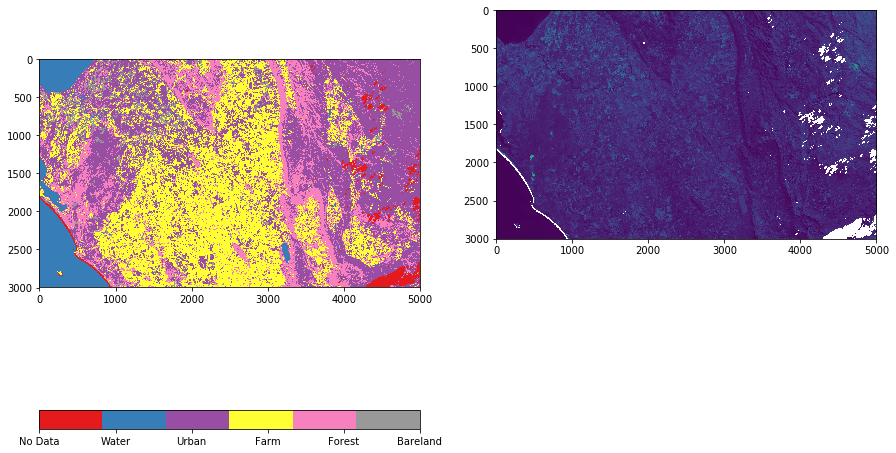

In [31]:
r = pred_pixels.Red_Band.values
r = np.where(r!=-999, r, np.nan)

classes = ["No Data","Water","Urban","Farm","Forest","Bareland"]
plt.figure(figsize=(15,15))
cmap = plt.cm.get_cmap("Set1",6)
plt.subplot(1,2,1)
plt.imshow(land_pred, cmap=cmap)
ticks = np.arange(1,7)
colorbar = plt.colorbar(ticks=ticks, orientation = "horizontal")
colorbar.set_ticklabels(classes)
plt.subplot(1,2,2)
plt.imshow(r.reshape(3000,5000))

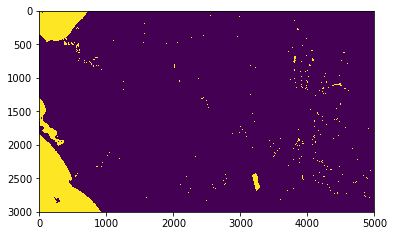

In [32]:
plt.imshow(land_pred==2)

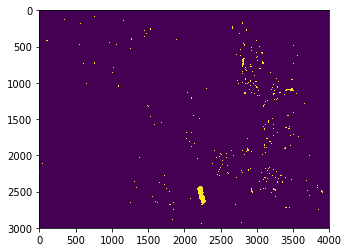

In [40]:
no_sea = land_pred[0:3000,1000:5000]
plt.imshow(no_sea==2)

In [41]:
no_sea==2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [49]:
# Calculate area surface
unique, counts = np.unique(no_sea, return_counts=True)
class_counts = pd.DataFrame({"Classes":unique,
                             "Class Names": classes,
                            "Count":counts,
                            "Area (m$^{2}$)":counts*900})
class_counts

,Classes,Class Names,Count,Area (m$^{2}$)
0,1,No Data,238322,214489800
1,2,Water,77614,69852600
2,3,Urban,4793280,4313952000
3,4,Farm,4170299,3753269100
4,5,Forest,2177689,1959920100
5,6,Bareland,542796,488516400


In [50]:
pwd

'/vault/users/dara104'

In [56]:
np.save('/vault/users/dara104/Classified_Arrays/2014',no_sea)